In [1]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from collections import OrderedDict
from Utils import Neuron, reestimate_params, multi_root
from scipy.stats import multivariate_normal
from copy import deepcopy

from matplotlib.patches import Ellipse

In [17]:
class Merging:
    def __init__(self, neurons, betta):
        self.neurons_ = deepcopy(neurons)
        self.neurons_nb_ = len(neurons)
        self.betta_ = betta


    def combine_gmm_ridgeline(self):
        ratios = np.zeros((self.neurons_nb_, self.neurons_nb_))
        key_to_idx = {key:index for index, key in enumerate(self.neurons_.keys())}

        # Precomputing
        for key1, neuron1 in self.neurons_.items():
            for key2, neuron2 in self.neurons_.items():
                idx1, idx2 = key_to_idx[key1], key_to_idx[key2]
                if key1 < key2 and not ratios[idx1, idx2]:
                    ratio = self.estimated_ratio(neuron1, neuron2)
                    ratios[idx1, idx2] = ratio
                    ratios[idx2, idx1] = ratio
        
        print("Precomputed!")

        while self.neurons_nb_ >= 2:
            max_ratio = -np.inf

            # Finding best pair
            for key1 in self.neurons_.keys():
                for key2 in self.neurons_.keys():
                    idx1, idx2 = key_to_idx[key1], key_to_idx[key2]

                    if ratios[idx1, idx2] > max_ratio:
                        max_ratio = ratios[idx1, idx2]
                        best_pair = (key1, key2)

            print("Best pair ->", best_pair)
            print("Max ratio ->", max_ratio)

            if max_ratio >= self.betta_:
                # Reestimate parameters of merged pair and save to smallest neuron key
                reestimate_params(self.neurons_[best_pair[0]], 
                                  self.neurons_[best_pair[1]])

                ratios[key_to_idx[best_pair[1]], :] = -np.inf
                ratios[:, key_to_idx[best_pair[1]]] = -np.inf

                # Remove the largest neuron key
                del self.neurons_[best_pair[1]]
                key_to_idx[best_pair[1]] = None
                self.neurons_nb_ -= 1
    
                print("Merged -> {}, {}".format(best_pair[0], best_pair[1]))

                self.H_ = np.eye(self.neurons_nb_)

                # Update ratios for merged neuron and other neurons
                merged_neuron = self.neurons_[best_pair[0]]
                for key, neuron in self.neurons_.items():
                    if key != best_pair[0]:
                        ratio = self.estimated_ratio(merged_neuron, neuron)
                        idx1, idx2 = key_to_idx[best_pair[0]], key_to_idx[key]
                        ratios[idx1, idx2] = ratio
                        ratios[idx2, idx1] = ratio
                
            else:
                break
                

    def estimated_ratio(self, model1:Neuron, model2:Neuron):
        # Check whether to merge two cluster based on r_val 
        alpha = model1.weight_ / (model1.weight_ + model2.weight_)
        dfunc = lambda x, model1, model2: self.piridge(x, model1, model2) - alpha

        roots = multi_root(dfunc, [0, 1], args=(model1, model2))

        if len(roots) == 1:
            return 1
        
        values = np.sort(self.f(roots, model1, model2))
        global_min, second_max = values[0], values[-2]

        return global_min / second_max


    def piridge(self, alpha, model1, model2):
        if isinstance(alpha, float):
            alpha = np.array([alpha])

        X = self.to_ralpha(alpha, model1, model2)

        delta_min = 2.225e-300
        phi1 = multivariate_normal.pdf(X, mean=model1.mean_, cov=model1.cov_) + delta_min
        phi2 = multivariate_normal.pdf(X, mean=model2.mean_, cov=model2.cov_) + delta_min

        if not isinstance(phi1, np.ndarray):
            phi1 = np.array([phi1])
            phi2 = np.array([phi2])
        
        numerator = alpha * phi1
        denominator = (1 - alpha) * phi2
        mask = denominator > 0

        numerator = numerator[mask]
        denominator = denominator[mask]

        res = 1 / (1 + numerator / denominator)
        
        return np.concatenate((res, np.zeros(len(alpha) - np.sum(mask))))


    def f(self, alpha:np.ndarray, model1:Neuron, model2:Neuron):
        X = self.to_ralpha(alpha, model1, model2)
        
        sum_prob = model1.weight_ + model2.weight_
        
        return model1.weight_ / sum_prob * multivariate_normal.pdf(X, mean=model1.mean_, cov=model1.cov_) + \
                model2.weight_ / sum_prob  * multivariate_normal.pdf(X, mean=model2.mean_, cov=model2.cov_)


    @staticmethod
    def to_ralpha(alpha:np.ndarray, model1:Neuron, model2:Neuron):
        X = np.empty((alpha.shape[0], model1.mean_.shape[0]))
        
        inv_cov_1 = np.linalg.inv(model1.cov_)
        inv_cov_2 = np.linalg.inv(model2.cov_)

        for i, a in enumerate(alpha):
            X[i] = np.linalg.inv((1 - a) * inv_cov_1 + a * inv_cov_2) @ \
                        ((1 - a) * inv_cov_1 @ model1.mean_ + a * inv_cov_2 @ model2.mean_)

        return X

In [18]:
def generate_mixture(means, covariances, probabilities, n_samples, random_state=None):
    # Set random seed for reproducibility
    if random_state is not None:
        np.random.seed(random_state)

    mixture_indexes = np.random.choice(a=probabilities.size, p=probabilities, size=n_samples)
    
    labels = []
    data = []
    for idx in mixture_indexes:
        mean = means[idx]
        cov = covariances[idx]

        data.append(np.random.multivariate_normal(mean, cov))
        labels.append(idx)

    return np.array(data), np.array(labels)

In [19]:
n_samples = 500

# Define the parameters for the 2D Gaussian finite mixture
means = np.array([[-1, -2], [2, -5], [3.2, 6.2], [9.7, 4.7], [10, -3]])

# Define covariances for each component
covariances = np.array([[[1, 0], [0, 1]],  
                        [[1, 0.5], 
                         [0.5, 1]],  
                        [[1.1, 0.3], 
                         [0.3, 1]],
                        [[1.2, -0.9], [-0.9, 1.5]],
                        [[1, -0.9], [-0.9, 1]]])

probabilities = np.array([0.2, 0.15, 0.35, 0.2, 0.1])

In [20]:
data, labels = generate_mixture(means, covariances, probabilities, n_samples, 42)

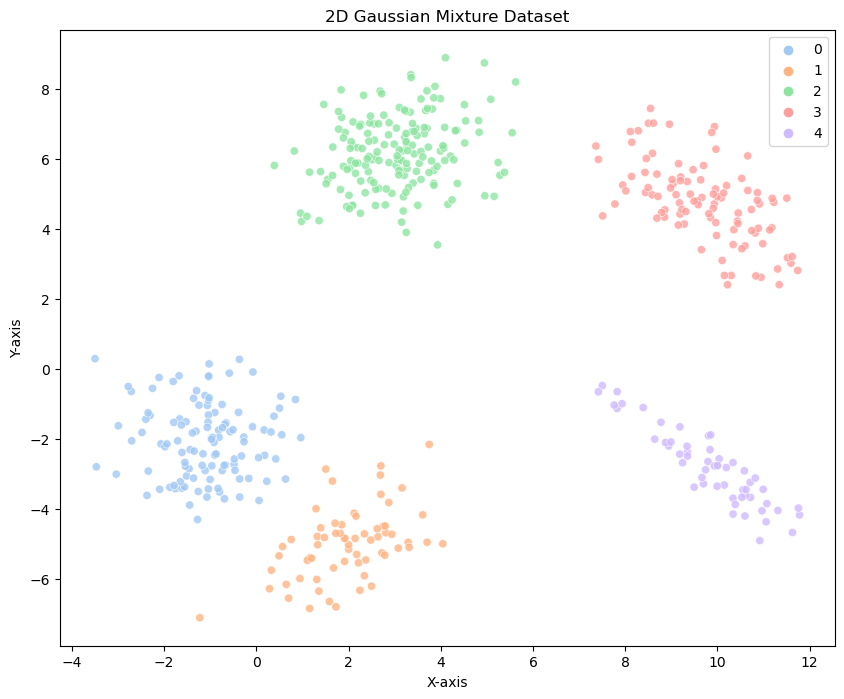

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))

# Generate data points from the 2D Gaussian mixture

custom_palette = sns.color_palette("pastel", len(np.unique(labels)))  # Use Seaborn's "husl" palette for n colors

# Visualize the generated data
sns.scatterplot(x=data[:, 0], y=data[:, 1], alpha=0.8, hue=labels, ax=ax, palette=custom_palette)

# for mean, color in zip(means, custom_palette):
#     ax.plot(mean[0], mean[1], color=color, markersize=14, marker='*')


ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('2D Gaussian Mixture Dataset');

In [22]:
neurons = OrderedDict()
for i in range(10*len(probabilities)):
    idx = i % len(probabilities)
    neurons[i] = Neuron(probabilities[idx], means[idx], covariances[idx])

In [23]:
neurons

OrderedDict([(0, <Utils.Neuron at 0x23063b6f210>),
             (1, <Utils.Neuron at 0x23062b96d90>),
             (2, <Utils.Neuron at 0x23062a71c50>),
             (3, <Utils.Neuron at 0x23062a73d10>),
             (4, <Utils.Neuron at 0x23063855350>),
             (5, <Utils.Neuron at 0x23063855010>),
             (6, <Utils.Neuron at 0x23062bbdb50>),
             (7, <Utils.Neuron at 0x23063854090>),
             (8, <Utils.Neuron at 0x23060353cd0>),
             (9, <Utils.Neuron at 0x23062ab9990>),
             (10, <Utils.Neuron at 0x23062c0ee90>),
             (11, <Utils.Neuron at 0x2306097d3d0>),
             (12, <Utils.Neuron at 0x23062ada750>),
             (13, <Utils.Neuron at 0x23062ad97d0>),
             (14, <Utils.Neuron at 0x23063866b90>),
             (15, <Utils.Neuron at 0x23063866510>),
             (16, <Utils.Neuron at 0x23063867c10>),
             (17, <Utils.Neuron at 0x23063866cd0>),
             (18, <Utils.Neuron at 0x230638666d0>),
             (19, <Uti

In [24]:
gmm_merging = Merging(neurons, 0.3)

In [25]:
gmm_merging.combine_gmm_ridgeline()

Precomputed!
Best pair -> (0, 5)
Max ratio -> 1.0
Merged -> 0, 5
Best pair -> (0, 10)
Max ratio -> 1.0
Merged -> 0, 10
Best pair -> (0, 15)
Max ratio -> 1.0
Merged -> 0, 15
Best pair -> (0, 20)
Max ratio -> 1.0
Merged -> 0, 20
Best pair -> (0, 25)
Max ratio -> 1.0
Merged -> 0, 25
Best pair -> (0, 30)
Max ratio -> 1.0
Merged -> 0, 30
Best pair -> (0, 35)
Max ratio -> 1.0
Merged -> 0, 35
Best pair -> (0, 40)
Max ratio -> 1.0
Merged -> 0, 40
Best pair -> (0, 45)
Max ratio -> 1.0
Merged -> 0, 45
Best pair -> (1, 6)
Max ratio -> 1.0
Merged -> 1, 6
Best pair -> (1, 11)
Max ratio -> 1.0
Merged -> 1, 11
Best pair -> (1, 16)
Max ratio -> 1.0
Merged -> 1, 16
Best pair -> (1, 21)
Max ratio -> 1.0
Merged -> 1, 21
Best pair -> (1, 26)
Max ratio -> 1.0
Merged -> 1, 26
Best pair -> (1, 31)
Max ratio -> 1.0
Merged -> 1, 31
Best pair -> (1, 36)
Max ratio -> 1.0
Merged -> 1, 36
Best pair -> (1, 41)
Max ratio -> 1.0
Merged -> 1, 41
Best pair -> (1, 46)
Max ratio -> 1.0
Merged -> 1, 46
Best pair -> (2, 7)

In [11]:
neurons = gmm_merging.neurons_

In [12]:
weights = []
means = []
covs = []

for weight, mean, cov in neurons.values():
    weights.append(weight)
    means.append(mean)
    covs.append(cov)

In [13]:
gmm_merging.neurons_

OrderedDict([(0, <Utils.Neuron at 0x23062aa2650>),
             (1, <Utils.Neuron at 0x23062bd6510>),
             (2, <Utils.Neuron at 0x23062bd54d0>),
             (3, <Utils.Neuron at 0x23062bd4210>),
             (4, <Utils.Neuron at 0x23062b4b9d0>)])

In [14]:
weights

[1.9999999999999998,
 1.4999999999999998,
 3.5000000000000004,
 1.9999999999999998,
 0.9999999999999999]

In [15]:
covs

[array([[1., 0.],
        [0., 1.]]),
 array([[1. , 0.5],
        [0.5, 1. ]]),
 array([[1.1, 0.3],
        [0.3, 1. ]]),
 array([[ 1.2, -0.9],
        [-0.9,  1.5]]),
 array([[ 1. , -0.9],
        [-0.9,  1. ]])]

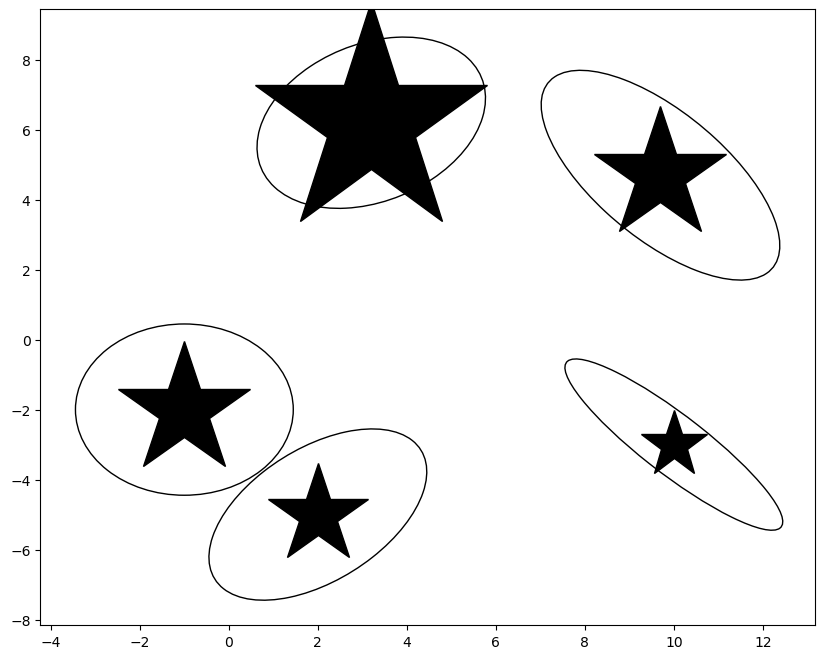

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))


for weight, mean, cov in zip(weights, means, covs):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    width, height = 2 * np.sqrt(5.991 * eigenvalues)
    ell = Ellipse(xy=mean, width=width, height=height, angle=angle, color='black', fill=False)
    ax.add_patch(ell)
    ax.plot(mean[0], mean[1], color='black', markersize=50*weight, marker='*')[0]

In [213]:
%timeit gmm_merging.estimated_ratio(neurons[0], neurons[10])

11.8 ms ± 978 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
